# Midterm (MACS 30100), February 5, 2018
### Zhiyu Fu
You will have an hour and thirty minutes to take this exam.
1. Put your name in the space provided above (without the brackets).
2. Download this notebook and accompanying data `LenderDataLong.dta`.
3. The class will disconnect their wi-fi and begin taking the exam.
4. The exam is open computer, closed internet, open note.
5. Once you are done, you will signal to a TA or instructor to come over and monitor while you reconnect to the internet and upload your edited notebook to Canvas.

Remember that you must clearly indicate your answers to all questions below. We will give partial credit for partially correct answers. The midterm is worth 20 points (2 problem sets).

## The data
This two exercises of this midterm and all their respective subparts will use the `LenderData.csv` dataset, which contains observations of characteristics on short-term, high interest rate, lender information. You are not to use this data outside of this class. It is a jittered and randomized version of a dataset used in a published research paper.

Each observation contains characteristics of a particular lender location Read it into Python using the `pandas.read_csv()` command. The variables are the following:

* `avgrate`: average annualized interest rate of all loans in percentage points (235 = two hundred and thirty five percent)
* `numstores`: number of other stores owned by the same owner (measure of size)
* `defrate`: default rate on loans from that store during 2010
* `pdrad3`: number of payday lenders within a three-mile radius of the store (measure of competition)
* `pnrad3`: number of pawn lenders within a three-mile radius of the store (measure of competition)
* `totrad3`: total number of other lenders within a three-mile radius of the store (measure of competition)
* `unrt_zip`: unemployment rate in the zip code of the store
* `medtotinc2010`: median total household income in the zip code of the store
* `edbachplus_zip`: average education level in years of schooling of heads of household in the zip code of the store
* `pop_zip`: population in zip code of the store
* `mdage_zip`: median age (in years) in zip code of the store
* `pctblk2_zip`: percent of the population that is black in the zip code of the store in percentage points (2.2=two point two percent)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
from scipy.optimize import minimize
import pdb
from matplotlib import rc
import statsmodels.api as sm
rc('text', usetex=True)

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
ld = pd.read_csv("LenderData.csv")
# Read in the data

## 1. Using the distributions of interest rates and median income (10 points)

1A) [2 points] Create a plot of the histogram of high interest rate lenders interest rates `avgrate`. Use 30 bins. Make sure to label your axes and give the figure a title. If you had to group lenders into $N$ categories, how many categories would you choose based on the interest rate data? That is, how many groupings to you see in these data?

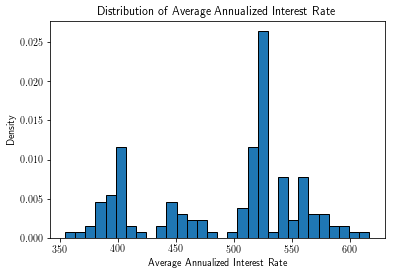

In [4]:
fig, ax = plt.subplots()
ax.hist(ld.avgrate, bins = 30, normed = True, edgecolor = "Black")
ax.set(xlabel = "Average Annualized Interest Rate", 
       ylabel = "Density", 
       title = "Distribution of Average Annualized Interest Rate")
fig

**Answer**

There is clearly pattern of three categories shown in the histogram.

1B) [1 point] Create a plot of the histogram of median total household income `medtotinc2010`. Use 30 bins. Make sure to label your axes and give the figure a title.

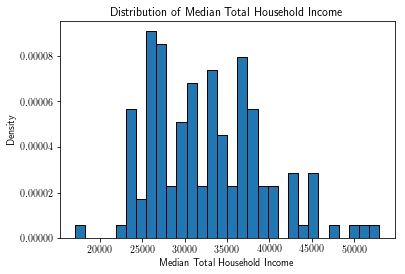

In [5]:
fig2, ax = plt.subplots()
ax.hist(ld.medtotinc2010, bins = 30, normed = True, edgecolor = "Black")
ax.set(xlabel = "Median Total Household Income", 
       ylabel = "Density", 
       title = "Distribution of Median Total Household Income")
fig2

1C) [5 points] Use maximum likelihood estimation to fit a lognormal distribution $LN(\mu, \sigma)$ to the median income data `medtotinc2010`. Report your estimated $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ as well as the likelihood function value at the maximum (not the negative log likelihood). Report your estimate of the variance-covariance matrix of your maximum likelihood estimates of $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$. Report the standard error on the estimate for $\hat{\mu}_{mle}$.

In [46]:
class Random_Variable:
    def log_lik(self, dt, param = None):
        return np.sum(np.log(self.pdf(dt, param)))
    
    def param_array(self):
        pass
    
    def pdf(self, x, param = None):
        pass
    
    def MLE(self, dt, bounds = None):
        def crit(param):
            return -self.log_lik(dt, param)
#         return minimize(crit, self.param_array(), method='L-BFGS-B', bounds = bounds)
        return minimize(crit, self.param_array(), method='BFGS')
    
    def cdf_integral(self, x):
        return integrate.quad(lambda x: self.pdf(x, param), 0, x)
        

class Log_Normal(Random_Variable):
    def __init__(self, mu, sigma):
        self.mu  = mu
        self.sigma = sigma
    
    def param_array(self):
        return np.array([self.mu, self.sigma])
    
    def pdf(self, x, param = None):
        if param is None:
            sigma = self.sigma
            mu = self.mu
            sigma2 = sigma ** 2
        else:
            mu, sigma = param
            sigma2 = sigma ** 2
        return 1/x/sigma/np.sqrt(2*np.pi) * np.exp(-(np.log(x)-mu)**2/2/sigma2)
    
    def cdf(self, x, param = None):
        if param is None:
            sigma = self.sigma
            mu = self.mu
        else:
            mu, sigma = param
        return sts.norm.cdf((np.log(x) - mu)/sigma)

In [47]:
lognormal = Log_Normal(10,0.3)
mle_res = lognormal.MLE(ld.medtotinc2010, bounds = ((5, 12), (1e-2,2)))

In [49]:
mle_res.hess_inv

array([[ 0.00049262,  0.00034015],
       [ 0.00034015,  0.0003175 ]])

**Answer**

In [27]:
class GMM:
    def __init__(self):
        pass
    
    def model_moment(self, param):
        pass
    
    def error_func(self, param, W = None):
        if W is None:
            W = np.eye(len(self.data_moment))
        e = (self.model_moment(param) - self.data_moment)/self.data_moment
        return e.T @ W @ e
    
    def vcv(self, param):
        e = (self.model_moment(param) - self.data_moment)/self.data_moment
        return e @ e.T / self.N
    
    def estimate(self, init, method = "identity", bounds = None):
        results = minimize(self.error_func, init, method='L-BFGS-B', bounds = bounds)
        if method == "identity":
            return results
        if method == "two-step":
            e = (self.model_moment(results.x) - self.data_moment)/self.data_moment
            vcv = e @ e.T / self.N
            W = np.linalg.inv(vcv)
            W = W/np.sum(W) # rescale the W in case of overflow
            results = minimize(self.error_func, results.x, args = W, method='L-BFGS-B',  bounds = bounds)
            return results
        if method == "iterate":
            W = np.eye(len(init))
            while True:
                e = (self.model_moment(results.x) - self.data_moment)/self.data_moment
                vcv = e @ e.T / self.N
                new_W = np.linalg.inv(vcv)
#                 new_W = new_W/np.sum(new_W) # rescale the W in case of overflow    
                if np.sum(np.abs(new_W - W))>1e-7:
                    W = new_W
                    results = minimize(self.error_func, results.x, args = (W), method='L-BFGS-B',  bounds = bounds)
                else:
                    return results    
                
class Log_Normal(GMM):
    def __init__(self, data):
        self.N = len(data)
        self.data = data
        self.data_moment = np.array((np.mean(self.data), np.std(self.data))).reshape((2,1))
        
    def model_moment(self, param):
#       Given the formula of model moment is easily calculated analytically,
#       I use the expression directly here instead of numerical integral to avoid inaccuracy and addtional offhead.
        param = np.array(param).reshape(2, 1)
        mean = np.exp(np.array((1, 0.5)).reshape((1,2)) @ param)
        std = np.sqrt(np.exp(np.array((2, 1)).reshape((1,2)) @ param) * (np.exp(param[1,:]) - 1))
        return np.concatenate((mean, std), axis = 0)
    
    def pdf(self, x, param):
        mu, sigma2 = param
        sigma = np.sqrt(sigma2)
        return 1/x/sigma/np.sqrt(2*np.pi) * np.exp(-(np.log(x)-mu)**2/2/sigma/sigma)
    
ln = Log_Normal(ld.medtotinc2010)
results = ln.estimate((11, 0.2), bounds = ((None, None), (1e-10, None)))

In [50]:
print(results)
np.sqrt(results.x[1])

      fun: array([[  6.31815004e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.66692994e-05,  -2.09222842e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 11
   status: 0
  success: True
        x: array([ 10.37735251,   0.03996197])


0.19990488993389433

In [38]:
print("mu_MLE = {}, sigma_MLE = {}, Log Likelihood = {}".format(mle_res.x[0], mle_res.x[1], -mle_res.fun))
OffDiagNeg = np.array([[1, -1], [-1, 1]])
VCV = mle_res.hess_inv.to_dense() * OffDiagNeg
print("VCV is:")
print(VCV)
print("Standard Error for mu is: {}".format(np.sqrt(VCV[0][0])))

mu_MLE = 10.377380213059086, sigma_MLE = 0.19949931021798967, Log Likelihood = -1497.1030088862096


AttributeError: 'numpy.ndarray' object has no attribute 'to_dense'

1D) [2 points] Plot the predicted distribution from your maximum likelihood estimates $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ against the histogram of the data.

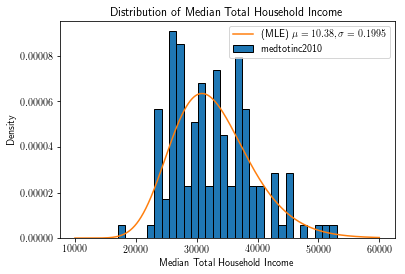

In [9]:
lognormal.mu, lognormal.sigma = mle_res.x
fig, ax = plt.subplots()
ax.hist(ld.medtotinc2010, bins = 30, normed = True, edgecolor = "Black")
ax.set(xlabel = "Median Total Household Income", 
       ylabel = "Density", 
       title = "Distribution of Median Total Household Income")
xval = np.linspace(10000, 60000, num = 1000)
yval = lognormal.pdf(xval)
ax.plot(xval, yval, label = "(MLE) $\mu = {}, \sigma = {}$".format(mle_res.x[0].round(2), mle_res.x[1].round(4)))
ax.legend(loc = "best")
fig

## 2. Determinants of lender interest rates (10 points)

2A) [3 points] Assume a simple regression model of four factors that influence the interest rates that a lender charges, namely, number of stores, default rate in the area, unemployment rate in the area, and median household income in the area.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + u_i $$

Estimate this model by OLS using the `statsmodels.api` package. Don't forget to include a constant. Print your results summary. Which variables are significant at the 5-percent level? How would you interpret in words the estimated coefficient on `numstores`?

In [10]:
X = ld.loc[:,["numstores", "defrate", "unrt_zip", "medtotinc2010"]]
X.loc[:,"const"] = np.ones((X.shape[0]))
X.describe()

,numstores,defrate,unrt_zip,medtotinc2010,const
count,147.000000,147.000000,147.000000,147.000000,147.0
mean,16.768707,14.160487,7.143537,32772.135390,1.0
std,7.760162,9.233870,1.984048,6639.982466,0.0
min,1.000000,0.700000,3.900000,17068.277340,1.0
25%,10.000000,6.607314,5.700000,27502.000000,1.0
50%,16.000000,11.674499,6.800000,31611.000000,1.0
75%,23.000000,19.089744,8.200000,36955.138670,1.0
max,28.000000,38.954868,12.800000,52972.890630,1.0


In [11]:
ols_res = sm.OLS(ld.avgrate, X, missing = "drop").fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgrate   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.375
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00229
Time:                        12:30:02   Log-Likelihood:                -812.28
No. Observations:                 147   AIC:                             1635.
Df Residuals:                     142   BIC:                             1650.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
numstores        -2.6278      0.672     -3.911      0.000      -3.956      -1.300
defrate           0.9717      0.574      1.694      0.093      -0.162       2.106
unrt_zip          2.9650      3.187      0.930      0.354      -3.335       9.265
medtotinc2010     0.0015      0.001      1.526      0.129      -0.000       0.003
const           453.4117     51.263      8.845      0.000     352.075     554.748
==============================================================================
Omnibus:                        5.028   Durbin-Watson:                   0.366
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                3.262
Skew:                          -0.189   Prob(JB):                        0.196
Kurtosis:                       2.375   Cond. No.                     3.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Answer**

Numstores is the only variable that is significant at 5% level.

The annualized interest rate significantly ($p<0.001$) decreases in 2.6278 for every more stores the owner owns.

2B) [4 points] Now assume a richer model for the determinants of lender interest rates, which includes the following measures of competition and other demographic variables.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + ... $$
$$ \qquad\qquad\qquad\qquad \beta_5 totrad3_i + \beta_6 edbachplus\_zip_i + \beta_7 pop\_zip_i + \beta_8 mdage\_zip_i + \beta_9 pctblk2\_zip_i + u_i $$

Estimate this regression by OLS using the `statsmodels.api` package. In controlling for these new varaibles, do any of the originally estimated coefficients from the model in part (2A) become statistically not significant (at the 5 percent level)? Of these new coefficients ($\beta_5$ through $\beta_9$), which one(s) are the most statistically significant?

In [12]:
X2 = pd.concat((X, ld.loc[:, ["totrad3", "edbachplus_zip", "pop_zip", "mdage_zip", "pctblk2_zip"]]), axis = 1)
ols_res2 = sm.OLS(ld.avgrate, X2, missing = "drop").fit()
ols_res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgrate   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     2.846
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00419
Time:                        12:30:02   Log-Likelihood:                -808.23
No. Observations:                 147   AIC:                             1636.
Df Residuals:                     137   BIC:                             1666.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
numstores         -2.4303      0.680     -3.574      0.000      -3.775      -1.086
defrate            0.8094      0.585      1.384      0.168      -0.347       1.966
unrt_zip          -0.3055      3.521     -0.087      0.931      -7.268       6.657
medtotinc2010      0.0010      0.001      0.843      0.401      -0.001       0.003
const            613.9741     85.491      7.182      0.000     444.921     783.027
totrad3           -0.6991      0.527     -1.326      0.187      -1.741       0.343
edbachplus_zip    -1.3219      0.660     -2.004      0.047      -2.626      -0.018
pop_zip           -0.0006      0.000     -1.539      0.126      -0.001       0.000
mdage_zip         -1.8352      2.234     -0.821      0.413      -6.253       2.583
pctblk2_zip        2.3541      5.981      0.394      0.694      -9.473      14.181
==============================================================================
Omnibus:                        2.316   Durbin-Watson:                   0.443
Prob(Omnibus):                  0.314   Jarque-Bera (JB):                2.014
Skew:                          -0.174   Prob(JB):                        0.365
Kurtosis:                       2.543   Cond. No.                     8.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Answer**
1. No. Numstores is still significant.
2. Of those new variables, edbachplus_zip (average education level in years of schooling of heads of household) is the only one that is statistically significant at 5% level.

2C) [3 points] Create a new binary variable called `avgrate_high` that equals 1 if `avgrate` > 490, and equals 0 otherwise. Estimate a logistic regression using the `statsmodels.api` package. Let $X\beta$ be the linear coefficients and variables from the model from part (2B).

$$ Pr(avgrate\_high=1|X\beta) = \frac{X\beta}{1 + X\beta} $$

Report the variables whose coefficients are estimated to be significant at the 5-percent level.

In [13]:
ld.loc[:,"avgrate_high"] = (ld.avgrate>490).astype("int")
logit = sm.Logit(ld.avgrate_high, X2, missing = "drop").fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.559372
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           avgrate_high   No. Observations:                  147
Model:                          Logit   Df Residuals:                      137
Method:                           MLE   Df Model:                            9
Date:                Mon, 05 Feb 2018   Pseudo R-squ.:                  0.1493
Time:                        12:30:02   Log-Likelihood:                -82.228
converged:                       True   LL-Null:                       -96.657
                                        LLR p-value:                 0.0006848
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
numstores         -0.0461      0.025     -1.847      0.065      -0.095       0.003
defrate            0.0931      0.026      3.598      0.000       0.042       0.144
unrt_zip           0.0271      0.131      0.207      0.836      -0.230       0.284
medtotinc2010   6.317e-05   4.95e-05      1.276      0.202   -3.39e-05       0.000
const              1.7313      3.261      0.531      0.595      -4.659       8.122
totrad3           -0.0290      0.021     -1.380      0.168      -0.070       0.012
edbachplus_zip    -0.0368      0.026     -1.415      0.157      -0.088       0.014
pop_zip        -3.021e-05   1.66e-05     -1.819      0.069   -6.28e-05    2.34e-06
mdage_zip         -0.0375      0.083     -0.451      0.652      -0.201       0.126
pctblk2_zip       -0.0096      0.229     -0.042      0.967      -0.459       0.440
==================================================================================
"""

**Answer**

Defrate is the only one that is significant at 5-percent level.